# Biological Data Final Exam - Protein Family

## Mounting drive and package installation

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
data_dir = '/content/drive/MyDrive/BD_final_project/data'

In [ ]:
!pip install biopython

In [ ]:
#@title Protein Domain Information
uniprot_accession = "O43099"
pfam_id = "PF08534"
pfam_name = "Redoxin"
domain_sequence = "KAGDSFPSDVVFSYIPWSEDKGEITACGIPINYNASKEWADKKVILFALPGAFTPVCSARHVPEYIEKLPEIRAKGVDVVAVLAYNDAYVMSAWGKANQVTGDDILFLSDPDARFSKSIGWADEEGRTKRYALVIDHGKITYAALEPAKNHLEFSSAETVL"

In [ ]:
from Bio.Blast import NCBIXML
from Bio import SeqIO

## Models Building

### Blast Search
Search homologous sequences with the EBI BLAST [webservice](https://www.ebi.ac.uk/Tools/sss/ncbiblast/).


1. Select Database
```
PROTEIN DATABASES --> UniProt Knowledgebase
```
2. Paste the sequence
Click "More options" button
```
ALIGNMENTS --> 1000  # Maximum number of match alignments reported in the result output
ALIGNMENT VIEWS --> BLASTXML  # important!
```
3. When finished
```
"Tool output" --> Right click "Download" --> "Save link as..."
```

N.B. Do not click on "Download in XML format" otherwise the Python parser won't work!

In [ ]:
#@title Extracting Hit IDs from BLAST Alignment Results

from Bio.Blast import NCBIXML
from Bio import SeqIO

# Load BLAST XML result file
result_handle = open("{}/blast_alignment_result.xml".format(data_dir))
blast_records = NCBIXML.parse(result_handle)

# Specify the output file
output_file = "{}/blast_sequences.txt".format(data_dir)

# Open the output file in write mode
with open(output_file, 'w') as out_handle:
    # Iterate through BLAST records
    for blast_record in blast_records:
        for alignment in blast_record.alignments:
            # Get the hit ID
            hit_id = alignment.hit_id.split(":")[1]


            # Write the hit_id to the output file
            out_handle.write(hit_id + '\n')


### UniProtKB Web Tool
The UniProtKB website offers the [Retrieve/ID mapping](https://www.uniprot.org/id-mapping) service where you can provide the list of UniProtKB accessions.

```
From database --> UniProt --> UniProtKB AC/ID
To database --> UniProt
```

```
Completed --> Download --> Fasta --> "idmapping_blast_sequences.fasta"
```

### MSA with Clustal Omega

1. Paste the un-aligned sequences in [Clustal Omega](https://www.ebi.ac.uk/Tools/msa/clustalo/) web service
  - idmapping_blast_sequences.fasta

2. Select format
```
OUTPUT FORMAT --> Pearson/FASTA
```

3. Save output
```
Right click "Download Alignment File" --> "Save Link As..." --> "clustalo-output.fasta"
```



### Optional: Edit MSA with JaalView

1. Select all the columns that are not conserved (i.e. that have '-' in the conservation histogram) and remove them.
```
edit -> cut
```

2. Remove redundant rows
```
edit -> remove redundancy -> threshold = 100
```
By keeping the redundancy threshold at 100, only identical sequences are removed

### Building the Models

**PSSM** using [PSI-BLAST](https://ftp.ncbi.nlm.nih.gov/blast/executables/blast+/LATEST/?fbclid=IwAR3ioaI-pNIh9NKNaWoCFczpgmxmrZLZONKmhwQ4AEzQq9kJnj_wbnQKbqA)
```
psiblast -subject "C:\Users\nikol\Documents\GitHub\protein-family-model\idmapping_blast_sequences.fasta" -in_msa "C:\Users\nikol\Documents\GitHub\protein-family-model\clustalo-output.fasta" -out_ascii_pssm "C:\Users\nikol\Documents\GitHub\protein-family-model\psiblast_output.pssm_ascii" -out_pssm "C:\Users\nikol\Documents\GitHub\protein-family-model\psiblast_output.pssm"
```
With the edited MSA
```
psiblast -subject "C:\Users\nikol\Documents\GitHub\protein-family-model\idmapping_blast_sequences.fasta" -in_msa "C:\Users\nikol\Documents\GitHub\protein-family-model\clustalo-edited.fa" -out_ascii_pssm "C:\Users\nikol\Documents\GitHub\protein-family-model\psiblast_output_edited.pssm_ascii" -out_pssm "C:\Users\nikol\Documents\GitHub\protein-family-model\psiblast_output_edited.pssm"
```

### Install the HMM software

HMMER (source, ~20 Mb)
```
wget http://eddylab.org/software/hmmer/hmmer.tar.gz
tar -xzf hmmer.tar.gz
cd hmmer-3.4
./configure
make
# Test
./src/hmmbuild
```


### Build HMM

**HMM** from the edited Clustal-Omega MSA
```
hmmer-3.4/src/hmmbuild /home/bogdana/clustalo-hmm.hmm /home/bogdana/clustalo-output.fasta
```
With the edited MSA
```
hmmer-3.4/src/hmmbuild /home/bogdana/clustalo-hmm-edited.hmm /home/bogdana/clustalo-edited.fasta
```

## Model Evaluation

Running the evaluations for the original models and the models that were constructed using the edited MSA

**PSSM** [NCBI BLAST](https://blast.ncbi.nlm.nih.gov/Blast.cgi?PROGRAM=blastp)

```
"Enter Query Sequence" --> Upload the PSSM file
"Database" --> "UniProtKB/Swiss-Prot(swissprot)"
"Program Selection" --> "PSI-BLAST (Position-Specific Iterated BLAST)"
"Download" --> "Hit table (CSV)"
```

**HMM** [HMMSEARCH](https://www.ebi.ac.uk/Tools/hmmer/search/hmmsearch)

```
Provide the HMM
"Sequence Database" --> "SwissProt"
"Download" --> "Tab delimited"
```

The **PF08534** Pfam matches in the SwissProt database can be retrieved directly from HMMER website.

```
HMMSEARCH --> Accession Search --> "PF08534@Pfam"
"Sequence Database" --> "SwissProt"
"Download" --> "Tab delimited" --> "pfam_search_results.tsv"
```

However the HMMSEARCH web site provides UniProt ID and not Accessions. They need to be mapped with the UniProt mapping service.
```
target_accessions.txt  # List of UniProt IDs
accessions_mappings.tsv  # UniProt IDs to UniProt Accessions
```

In [ ]:
#@title Extracting Target Accessions from Pfam Domain Results

# input file
input_file = "{}/pfam-domain-results.tsv".format(data_dir)

# output file for target accessions
output_file = "{}/target_accessions.txt".format(data_dir)

# Open the input file
with open(input_file, 'r') as in_handle:
    next(in_handle)

    with open(output_file, 'w') as out_handle:
        for line in in_handle:
            columns = line.strip().split('\t')
            target_accession = columns[1]
            out_handle.write(target_accession + '\n')


After that run the UniProt [Retrieve/ID mapping](https://www.uniprot.org/id-mapping) service to obtain accessions from the extracted IDs

```
From database --> UniProt --> UniProtKB AC/ID
To database --> UniProt
```

```
Completed --> Download --> TSV --> Select only "From" and "Entry"
```
This corresponds to the UniProt IDs and accessions.

In [ ]:
#@title Merging Pfam Domain Results with Accession Mappings

import pandas as pd

df_gt = pd.read_csv('{}/pfam-domain-results.tsv'.format(data_dir), sep='\t')

df_mapping = pd.read_csv('{}/accession_mappings.tsv'.format(data_dir), sep='\t')

df_gt = pd.merge(df_gt, df_mapping, left_on='Target Accession', right_on=['From'], how='inner')
df_gt

,Target Name,Target Accession,Target Length,Query Name,Query Accession,Query Length,E-value,Score,Bias,Domain Index,...,Target Env. Start,Target Env. End,Acc,Description,Mapped PDB(s),Number of Identical Sequences,From,Entry,Entry Name,Protein names
0,PRX5_ASPFU,PRX5_ASPFU,168,Redoxin,-,147,3.900000e-36,128.8,0.0,1,...,5,165,0.94,Peroxiredoxin Asp f3,5j9b_A,0,PRX5_ASPFU,O43099,PRX5_ASPFU,Peroxiredoxin Asp f3 (Prx) (EC 1.11.1.24) (Thi...
1,PRX5_PENCI,PRX5_PENCI,167,Redoxin,-,147,1.100000e-35,127.4,0.0,1,...,4,164,0.93,Peroxiredoxin Pen c 3,NaN,0,PRX5_PENCI,Q9Y8B8,PRX5_PENCI,Peroxiredoxin Pen c 3 (Prx) (EC 1.11.1.24) (Pe...
2,PRX5_EMENI,PRX5_EMENI,168,Redoxin,-,147,8.200000e-34,121.3,0.0,1,...,5,165,0.93,Putative peroxiredoxin prxA,NaN,0,PRX5_EMENI,Q5ASN8,PRX5_EMENI,Putative peroxiredoxin prxA (Prx) (EC 1.11.1.2...
3,PR2E2_ORYSJ,PR2E2_ORYSJ,225,Redoxin,-,147,4.000000e-33,119.1,0.0,1,...,64,222,0.91,"Peroxiredoxin-2E-2, chloroplastic",NaN,0,PR2E2_ORYSJ,Q7F8S5,PR2E2_ORYSJ,"Peroxiredoxin-2E-2, chloroplastic (EC 1.11.1.2..."
4,PR2E1_ORYSJ,PR2E1_ORYSJ,232,Redoxin,-,147,4.200000e-33,119.0,0.0,1,...,72,229,0.91,"Peroxiredoxin-2E-1, chloroplastic",NaN,0,PR2E1_ORYSJ,Q69TY4,PR2E1_ORYSJ,"Peroxiredoxin-2E-1, chloroplastic (EC 1.11.1.2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,PDIA2_PONAB,PDIA2_PONAB,525,Redoxin,-,147,5.900000e-03,21.2,0.0,1,...,383,457,0.82,Protein disulfide-isomerase A2,NaN,0,PDIA2_PONAB,Q5RCH2,PDIA2_PONAB,Protein disulfide-isomerase A2 (EC 5.3.4.1)
482,NXNL1_HUMAN,NXNL1_HUMAN,212,Redoxin,-,147,6.400000e-03,21.1,0.0,1,...,11,147,0.80,Nucleoredoxin-like protein 1,NaN,0,NXNL1_HUMAN,Q96CM4,NXNL1_HUMAN,Nucleoredoxin-like protein 1 (Thioredoxin-like...
483,THIO2_CHLTE,THIO2_CHLTE,109,Redoxin,-,147,6.400000e-03,21.1,0.1,1,...,4,55,0.73,Thioredoxin 2,NaN,0,THIO2_CHLTE,Q8KE49,THIO2_CHLTE,Thioredoxin 2 (Trx-2)
484,THIO_PORPU,THIO_PORPU,107,Redoxin,-,147,8.300000e-03,20.7,0.0,1,...,5,95,0.86,Thioredoxin,NaN,0,THIO_PORPU,P51225,THIO_PORPU,Thioredoxin (Trx)


In [ ]:
#@title Calculating Performance Metrics for Sequence Alignment Models(Protein level)

import numpy as np
import warnings
warnings.filterwarnings("ignore", "In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.", FutureWarning)


def calculate_metrics(tp, fp, fn):
    tn = 570420 - (tp + fp + fn)
    precision = tp / (tp + fp) if tp + fp != 0 else np.nan
    recall = tp / (tp + fn) if tp + fn != 0 else np.nan
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall != 0 else np.nan
    balanced_accuracy = 0.5 * ((tp / (tp + fn)) + (tn / (tn + fp))) if tp + fn + tn + fp != 0 else np.nan
    mcc_numerator = (tp * tn) - (fp * fn)
    mcc_denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    mcc = mcc_numerator / mcc_denominator if mcc_denominator != 0 else np.nan
    return precision, recall, f1_score, balanced_accuracy, mcc

# Calculate the confusion matrix
data = []

# HMMSEARCH
gt = set(df_gt[df_gt['E-value']< 0.01]['Target Accession'])
hmmsearch_files = ['hmmsearch_predictions.tsv', 'hmmsearch_predictions_edited.tsv']
hmm_names = ['HMM', 'HMM for conserved']
for hmmsearch_file, hmm_name in zip(hmmsearch_files, hmm_names):
  df = pd.read_csv('{}/{}'.format(data_dir, hmmsearch_file), sep="\t")
  pred = set(df.loc[df['E-value'] < 0.01]['Target Accession'])
  tp = len(gt.intersection(pred))
  fp = len(pred - gt)
  fn = len(gt - pred)
  precision, recall, f1_score, balanced_accuracy, mcc = calculate_metrics(tp, fp, fn)
  data.append([hmm_name, tp, fp, fn, precision, recall, f1_score, balanced_accuracy, mcc])

# PSI-BLAST
gt = set(df_gt[df_gt['E-value']< 0.01]['Entry'])
psiblast_files = ['Blast-Alignment-HitTable.csv', 'Blast-Alignment-HitTable-Edited.csv', 'conserved-pssm-hittable-iter2.csv', 'conserved-pssm-hittable-iter3.csv',
                  'conserved-pssm-hittable-iter4.csv', 'conserved-pssm-hittable-iter5.csv', 'conserved-pssm-hittable-iter6.csv', 'conserved-pssm-hittable-iter7.csv',
                  'unconserved-pssm-hittable-iter2.csv','unconserved-pssm-hittable-iter3.csv', 'unconserved-pssm-hittable-iter4.csv',
                  'unconserved-pssm-hittable-iter5.csv']
pssm_names = ['PSSM', 'Conserved PSSM - Iteration 1', 'Conserved PSSM - Iteration 2', 'Conserved PSSM - Iteration 3', 'Conserved PSSM - Iteration 4', 'Conserved PSSM - Iteration 5', 'Conserved PSSM - Iteration 6', 'Conserved PSSM - Iteration 7',
'unconserved PSSM - Iteration 2', 'unconserved PSSM - Iteration 3', 'unconserved PSSM - Iteration 4', 'unconserved PSSM - Iteration 5',]
for psiblast_file, pssm_name in zip(psiblast_files, pssm_names):
  df = pd.read_csv('{}/{}'.format(data_dir, psiblast_file), names=['query', 'subject', 'identity', 'alignment_length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bit_score', 'q_coverage'])
  df[['acc', 'version']] = df['subject'].str.split('.', 1, expand=True)
  pred = set(df.loc[df['evalue'] < 0.01]['acc'])
  tp = len(gt.intersection(pred))
  fp = len(pred - gt)
  fn = len(gt - pred)
  precision, recall, f1_score, balanced_accuracy, mcc = calculate_metrics(tp, fp, fn)
  data.append([pssm_name, tp, fp, fn, precision, recall, f1_score, balanced_accuracy, mcc])

columns = ['file', 'TP', 'FP', 'FN', 'Precision', 'Recall', 'F1 Score', 'Balanced Accuracy', 'MCC']
df = pd.DataFrame(data, columns=columns)

# Display the final DataFrame with metrics
df.head(20)

,file,TP,FP,FN,Precision,Recall,F1 Score,Balanced Accuracy,MCC
0,HMM,32,6,418,0.842105,0.071111,0.131148,0.535550,0.244586
1,HMM for conserved,47,0,403,1.000000,0.104444,0.189135,0.552222,0.323064
2,PSSM,32,0,418,1.000000,0.071111,0.132780,0.535556,0.266569
3,Conserved PSSM - Iteration 1,33,0,417,1.000000,0.073333,0.136646,0.536667,0.270702
4,Conserved PSSM - Iteration 2,145,2,305,0.986395,0.322222,0.485762,0.661109,0.563616
5,Conserved PSSM - Iteration 3,233,5,217,0.978992,0.517778,0.677326,0.758885,0.711825
6,Conserved PSSM - Iteration 4,249,10,201,0.961390,0.553333,0.702398,0.776658,0.729217
7,Conserved PSSM - Iteration 5,254,13,196,0.951311,0.564444,0.708508,0.782211,0.732630
8,Conserved PSSM - Iteration 6,264,18,186,0.936170,0.586667,0.721311,0.793318,0.740945
9,Conserved PSSM - Iteration 7,270,22,180,0.924658,0.600000,0.727763,0.799981,0.744694


In [ ]:
#@title Calculating Performance Metrics for Sequence Alignment Models(Residue level)

import numpy as np
import pandas as pd

def calculate_per_residue_metrics(model_start, model_end, gt_start, gt_end, target_length):

    # Calculate true positives, false positives, and false negatives
    tp = len(set(range(model_start, model_end + 1)).intersection(set(range(gt_start, gt_end + 1))))
    fp = max(0, model_end - model_start + 1 - tp)
    fn = max(0, gt_end - gt_start + 1 - tp)

    # Calculate true negatives
    tn = target_length - (tp + fp + fn)

    return tp, fp, fn, tn

def calculate_final_per_residue_metrics(tp, fp, fn, tn):
    precision = tp / (tp + fp) if tp + fp != 0 else np.nan
    recall = tp / (tp + fn) if tp + fn != 0 else np.nan
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall != 0 else np.nan
    balanced_accuracy = 0.5 * ((tp / (tp + fn)) + (tn / (tn + fp))) if tp + fn + tn + fp != 0 else np.nan
    mcc_numerator = (tp * tn) - (fp * fn)
    mcc_denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    mcc = mcc_numerator / mcc_denominator if mcc_denominator != 0 else np.nan
    return precision, recall, f1_score, balanced_accuracy, mcc


# Calculate the confusion matrix
data = []

# HMMSEARCH
hmmsearch_files = ['hmmsearch_predictions.tsv', 'hmmsearch_predictions_edited.tsv']
hmm_names = ['HMM', 'HMM for conserved']

for hmmsearch_file, hmm_name in zip(hmmsearch_files, hmm_names):
    df = pd.read_csv('{}/{}'.format(data_dir, hmmsearch_file), sep="\t")
    tp_total = 0
    fp_total = 0
    fn_total = 0
    tn_total = 0
    for _, pred in df.iterrows():
        for _, actual in df_gt.iterrows():
            if pred['Target Accession'] == actual['Target Accession']:

                model_start, model_end = pred['Target Ali. Start'], pred['Target Ali. End']
                gt_start, gt_end = actual['Target Ali. Start'], actual['Target Ali. End']
                target_length = actual['Target Length']

                tp, fp, fn, tn = calculate_per_residue_metrics(model_start, model_end, gt_start, gt_end, target_length)
                tp_total += tp
                fp_total += fp
                fn_total += fn
                tn_total += tn

    precision, recall, f1_score, balanced_accuracy, mcc = calculate_final_per_residue_metrics(tp_total, fp_total, fn_total, tn_total)
    data.append([hmm_name, tp_total, fp_total, fn_total, tn_total, precision, recall, f1_score, balanced_accuracy, mcc])

#PSI-BLAST
psiblast_files = ['Blast-Alignment-HitTable.csv', 'Blast-Alignment-HitTable-Edited.csv', 'conserved-pssm-hittable-iter2.csv', 'conserved-pssm-hittable-iter3.csv',
                  'conserved-pssm-hittable-iter4.csv', 'conserved-pssm-hittable-iter5.csv', 'conserved-pssm-hittable-iter6.csv', 'conserved-pssm-hittable-iter7.csv',
                  'unconserved-pssm-hittable-iter2.csv','unconserved-pssm-hittable-iter3.csv', 'unconserved-pssm-hittable-iter4.csv',
                  'unconserved-pssm-hittable-iter5.csv']
pssm_names = ['PSSM', 'Conserved PSSM - Iteration 1', 'Conserved PSSM - Iteration 2', 'Conserved PSSM - Iteration 3', 'Conserved PSSM - Iteration 4', 'Conserved PSSM - Iteration 5', 'Conserved PSSM - Iteration 6', 'Conserved PSSM - Iteration 7',
'unconserved PSSM - Iteration 2', 'unconserved PSSM - Iteration 3', 'unconserved PSSM - Iteration 4', 'unconserved PSSM - Iteration 5',]
for psiblast_file, pssm_name in zip(psiblast_files, pssm_names):
    df = pd.read_csv('{}/{}'.format(data_dir, psiblast_file), names=['query', 'subject', 'identity', 'alignment_length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bit_score', 'q_coverage'])
    df[['acc', 'version']] = df['subject'].str.split('.', 1, expand=True)
    tp_total = 0
    fp_total = 0
    fn_total = 0
    tn_total = 0
    for _, pred in df.iterrows():
        for _, actual in df_gt.iterrows():
            if pred['acc'] == actual['Entry']:

                model_start, model_end = pred['s_start'], pred['s_end']
                gt_start, gt_end = actual['Target Ali. Start'], actual['Target Ali. End']
                target_length = actual['Target Length']

                tp, fp, fn, tn = calculate_per_residue_metrics(model_start, model_end, gt_start, gt_end, target_length)
                tp_total += tp
                fp_total += fp
                fn_total += fn
                tn_total += tn

    precision, recall, f1_score, balanced_accuracy, mcc = calculate_final_per_residue_metrics(tp_total, fp_total, fn_total, tn_total)
    data.append([pssm_name, tp_total, fp_total, fn_total, tn_total, precision, recall, f1_score, balanced_accuracy, mcc])

columns = ['file', 'TP', 'FP', 'FN', 'TN', 'Precision', 'Recall', 'F1 Score', 'Balanced Accuracy', 'MCC']
df = pd.DataFrame(data, columns=columns)

# Display the final DataFrame with metrics
df.head(20)

,file,TP,FP,FN,TN,Precision,Recall,F1 Score,Balanced Accuracy,MCC
0,HMM,4157,199,598,1507,0.954316,0.874238,0.912523,0.878795,0.712573
1,HMM for conserved,5635,124,1191,2413,0.978468,0.825520,0.895511,0.888322,0.709413
2,PSSM,4766,336,256,1570,0.934143,0.949024,0.941525,0.886369,0.783271
3,Conserved PSSM - Iteration 1,4654,270,378,1626,0.945167,0.924881,0.934914,0.891238,0.769400
4,Conserved PSSM - Iteration 2,21541,2099,1705,8848,0.911210,0.926654,0.918867,0.867456,0.742242
5,Conserved PSSM - Iteration 3,32165,7337,312,7011,0.814263,0.990393,0.893733,0.739516,0.607988
6,Conserved PSSM - Iteration 4,34056,9911,95,5352,0.774581,0.997218,0.871912,0.673935,0.513212
7,Conserved PSSM - Iteration 5,34951,11398,212,7139,0.754083,0.993971,0.857567,0.689546,0.524342
8,Conserved PSSM - Iteration 6,35626,12686,740,10397,0.737415,0.979651,0.841446,0.715035,0.537181
9,Conserved PSSM - Iteration 7,36815,14832,1484,14946,0.712820,0.961252,0.818602,0.731583,0.536954


## Taxonomy

In [ ]:
#@title Checking Information from Protein Lineage Sequence File

p = "{}/best-model-protein-lineage-1.fasta".format(data_dir)
l = list(SeqIO.parse(p, "fasta"))
for i in l:
  print(l[0])
    # print(i.id[9:])

ID: UniRef90_P30048
Name: UniRef90_P30048
Description: UniRef90_P30048 Thioredoxin-dependent peroxide reductase, mitochondrial n=39 Tax=Haplorrhini TaxID=376913 RepID=PRDX3_HUMAN
Number of features: 0
Seq('MAAAVGRLLRASVARHVSAIPWGISATAALRPAACGRTSLTNLLCSGSSQAKLF...VNQ')
ID: UniRef90_P30048
Name: UniRef90_P30048
Description: UniRef90_P30048 Thioredoxin-dependent peroxide reductase, mitochondrial n=39 Tax=Haplorrhini TaxID=376913 RepID=PRDX3_HUMAN
Number of features: 0
Seq('MAAAVGRLLRASVARHVSAIPWGISATAALRPAACGRTSLTNLLCSGSSQAKLF...VNQ')
ID: UniRef90_P30048
Name: UniRef90_P30048
Description: UniRef90_P30048 Thioredoxin-dependent peroxide reductase, mitochondrial n=39 Tax=Haplorrhini TaxID=376913 RepID=PRDX3_HUMAN
Number of features: 0
Seq('MAAAVGRLLRASVARHVSAIPWGISATAALRPAACGRTSLTNLLCSGSSQAKLF...VNQ')
ID: UniRef90_P30048
Name: UniRef90_P30048
Description: UniRef90_P30048 Thioredoxin-dependent peroxide reductase, mitochondrial n=39 Tax=Haplorrhini TaxID=376913 RepID=PRDX3_HUMAN
Number of feat

In [ ]:
#@title Install package ete3 and PyQt5
!pip3  -q --no-cache-dir install  PyQt5==5.11.3
!pip3  -q --no-cache-dir install  ete3

In [ ]:
#@title Getting lineage through api
from Bio import Entrez
from time import sleep

def get_lineage(tax_id):

  handle = Entrez.efetch(db="taxonomy", id=tax_id, retmode="xml")
  taxonomy_record = Entrez.read(handle)
  lineage = taxonomy_record[0]["LineageEx"]
  scientific_names = [entry['ScientificName'] for entry in lineage]

  return scientific_names


import json
p = "{}/taxonomy-lineage.json".format(data_dir)
data = json.load(open(p))
list_items = []
lineage = {}
failed_items = []
for i in data["results"]:
  try:
    lineage_list = get_lineage(i["to"]["commonTaxon"]["taxonId"])
  except:
    if i["to"]["commonTaxon"]["scientificName"] not in  ["root", "cellular organisms"]:
      failed_items.append([i["from"], i["to"]["commonTaxon"]["taxonId"], i["to"]["commonTaxon"]["scientificName"]])
      print([i["from"], i["to"]["commonTaxon"]["taxonId"], i["to"]["commonTaxon"]["scientificName"]])
    continue
  if i["from"] not in lineage:
    lineage[i["from"]] = lineage_list
  list_items.append([i["from"], i["to"]["commonTaxon"]["taxonId"], i["to"]["commonTaxon"]["scientificName"], ",".join(lineage_list)])
  # sleep(0.5)


/usr/local/lib/python3.10/dist-packages/Bio/Entrez/__init__.py:723: UserWarning: 
            Email address is not specified.

            To make use of NCBI's E-utilities, NCBI requires you to specify your
            email address with each request.  As an example, if your email address
            is A.N.Other@example.com, you can specify it as follows:
               from Bio import Entrez
               Entrez.email = 'A.N.Other@example.com'
            In case of excessive usage of the E-utilities, NCBI will attempt to contact
            a user at the email address provided before blocking access to the
            E-utilities.
  warnings.warn(


['Q5RC63', 1437010, 'Boreoeutheria']
['P0AE08', 1, 'root']
['P0A251', 1, 'root']
['P99029', 131567, 'cellular organisms']
['P0AA86', 1, 'root']
['Q8DUK3', 1301, 'Streptococcus']
['P0AE52', 1, 'root']
['Q5HNJ2', 1, 'root']


,UNIPROT_ID,TAXON_ID,NAME,LINEAGE
0,P30048,376913,Haplorrhini,"cellular organisms,Eukaryota,Opisthokonta,Meta..."
1,Q5REY3,376913,Haplorrhini,"cellular organisms,Eukaryota,Opisthokonta,Meta..."
2,P35705,35500,Pecora,"cellular organisms,Eukaryota,Opisthokonta,Meta..."
3,Q9Z0V6,39107,Murinae,"cellular organisms,Eukaryota,Opisthokonta,Meta..."
4,P20108,39107,Murinae,"cellular organisms,Eukaryota,Opisthokonta,Meta..."


**In case if few api call fails use the below code to run and get the rest of it** *italicized text*

In [ ]:
#@title Getting lineage try 2 if needed

for i in failed_items:
  try:
    lineage_list = get_lineage(i[1])
  except:
    print(i)
    continue
  if i[0] not in lineage:
    lineage[i[0]] = lineage_list
  list_items.append([i[0], i[1], i[2], ",".join(lineage_list)])
  sleep(0.5)


In [ ]:
#@title Creating dataframe for UNIPROT_ID and TAXON_ID
l_df = pd.DataFrame(list_items,columns=["UNIPROT_ID", "TAXON_ID", "NAME", "LINEAGE"])
l_df = l_df[l_df["NAME"].str .contains("root|cellular organisms")== False]
l_df.head()

In [ ]:
len(l_df["TAXON_ID"].unique())

153

<span style="color:red">Outside code execution</span>.



> Use the unique `TAXON_ID` and upload it on this [CommonTree site](https://www.ncbi.nlm.nih.gov/Taxonomy/CommonTree/wwwcmt.cgi) and download lineage_tree.phy. We have used this tree to create tree with frequency


In [ ]:
#@title Count Tax occurence
freq_lineage = {}
for prot, tax in lineage.items():
    for elem in tax:
        freq_lineage[elem]=freq_lineage.setdefault(elem,0)+1
freq_lineage
"""{'cellular organisms': 288,
 'Eukaryota': 133,
 'Opisthokonta': 77,
 'Metazoa': 59,
 'Eumetazoa': 59,
 'Bilateria': 59}"""

In [ ]:
#@title Read phylogenetic tree
#@markdown <b> Issue with ete3 <a href= "https://github.com/etetoolkit/ete/issues/354">package</a></b>
from ete3 import Tree, TreeStyle, TextFace, NodeStyle, faces, AttrFace, CircleFace
tree=Tree(f"{data_dir}/ineage_tree.phy", format=1, quoted_node_names=True)

In [ ]:
#@title Function for tree creation
def layout(node):
    if node.is_leaf():
        N = AttrFace("name", fsize=35, fgcolor="black")
        faces.add_face_to_node(N, node, 0)
    if "weight" in node.features:
        C = CircleFace(radius=node.weight/2, color="Green", style="circle")
        C.opacity = 0.5
        faces.add_face_to_node(C, node, 0, position="float")

for i, n in enumerate(tree.traverse()):
    w = [value for key,value in freq_lineage.items()][i]
    n.add_features(weight=w)

ts = TreeStyle()
ts.title.add_face(TextFace("Perrxiredoxin AhpC2", fsize=90), column=0)
ts.scale =  100
ts.branch_vertical_margin = 10
ts.layout_fn = layout

ts.mode = "r"

ts.show_leaf_name = False
ts.show_branch_length = False
ts.show_branch_support = False
tree.show(tree_style=ts)
# tree.render(f"{data_dir}/lineage_tree.png", w= 250 ,h=250, units="mm",tree_style=ts,dpi=600)

### lineage tree
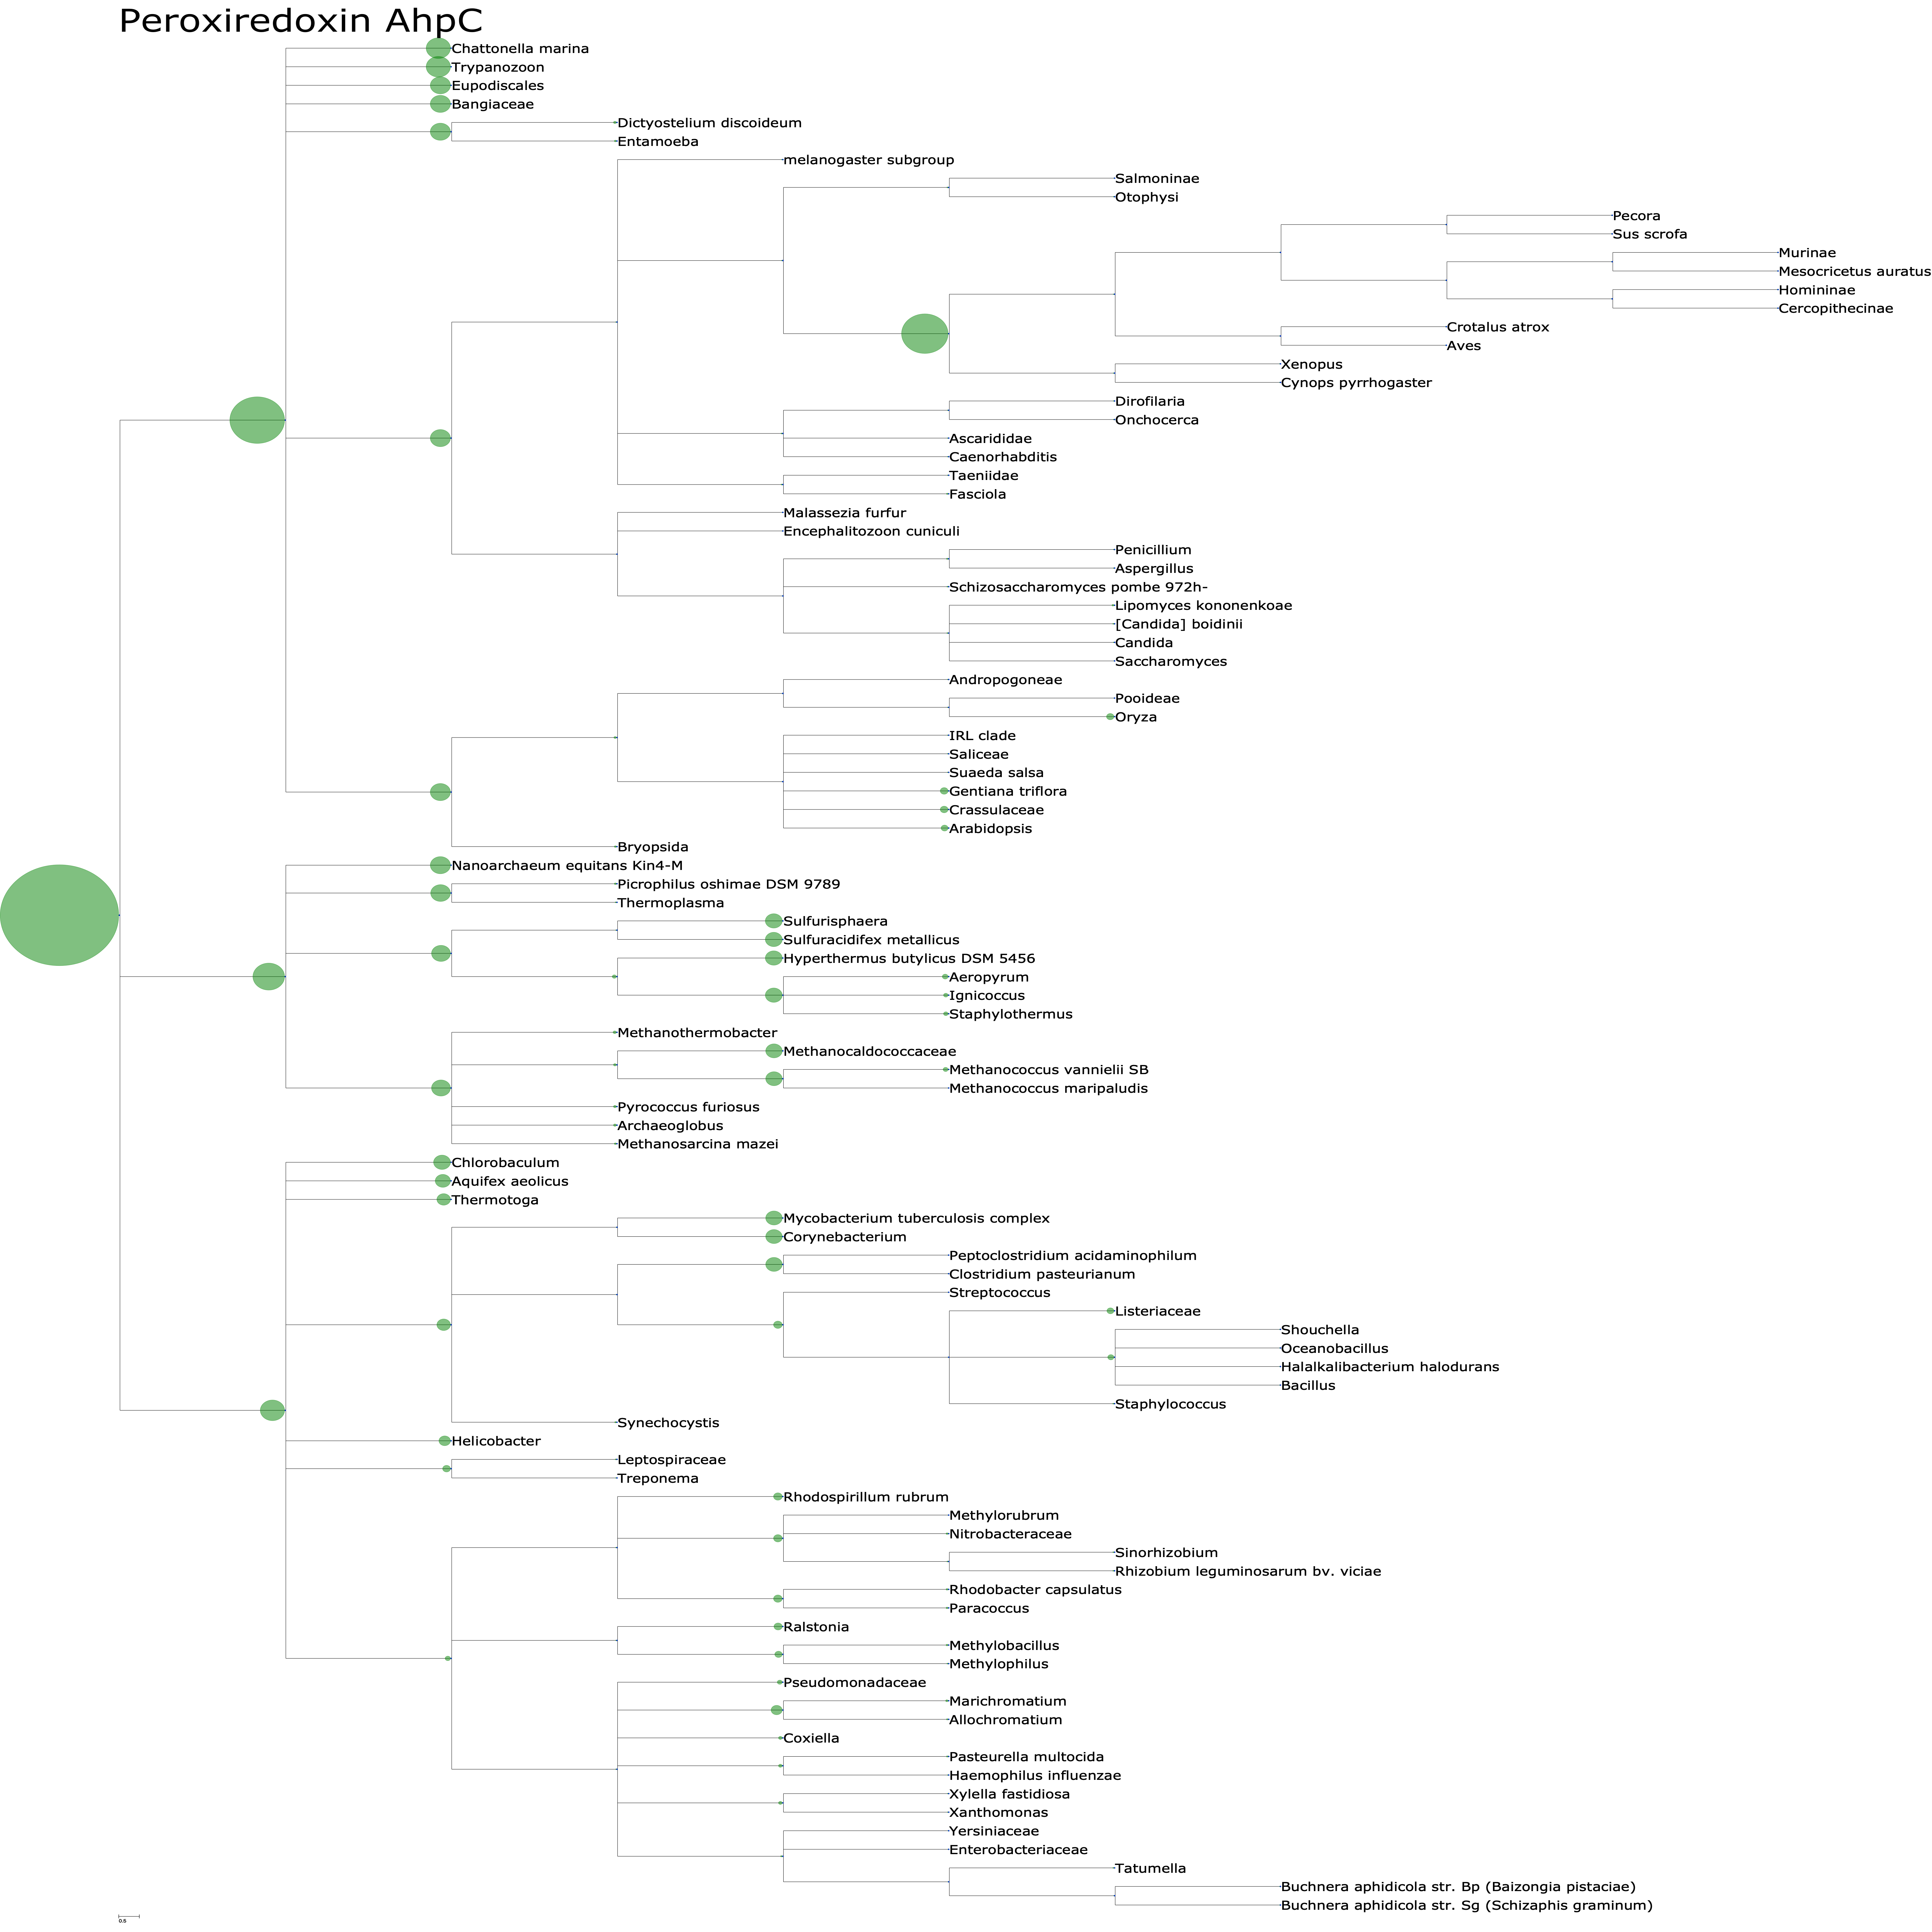

## Function

####  Processing uniprot_sprot.xml file for getting csv out of xml due to size issue

**Steps**

1. Download uniprot_sprot.xml from [here](https://www.uniprot.org/help/downloads).

2. As xml file is too big to process in RAM, we have used grep to process xml and get needed information in temporary file.
```
grep -E '<entry|<accession|<dbReference type="GO" id="GO:' uniprot_sprot.xml > processed_sprot.txt
```

3. Use below code to process processed_sprot.txt and get final_sprot_goa.csv file.

```
import re

def extract_go_annotations(entry):
    accession_match = re.findall(r"<accession>(.*?)<\/accession>", entry)

    go_matches = re.findall(r'<dbReference type="GO" id="GO:(.*?)">', entry)
    go_annotations = [f"GO:{go}" for go in go_matches]
    if not go_annotations:
        go_annotations = ["NOGO"]

    all_go_ids = ";".join(go_annotations)
    all_data = [f"{a},{all_go_ids}" for a in accession_match]

    text = "\n".join(all_data)

    text = text + "\n"

    return text


file_path = "processed_sprot.txt"

with open(file_path, "r") as file:
    in_entry = False
    entry_lines = []
    for line in file:
        if "<entry dataset" in line:
            if in_entry:
                entry = "".join(entry_lines)
                print(extract_go_annotations(entry), end="")
                entry_lines = []

            in_entry = True
        elif "<entry dataset" not in line:
            entry_lines.append(line)

    # Process the last entry if any
    if entry_lines:
        entry = "".join(entry_lines)
        print(extract_go_annotations(entry))
```



In [ ]:
#@title Import packages
import Bio
import pandas as pd
import requests
from pprint import pprint
import json
import gzip
import copy
from Bio import SeqIO, SearchIO
from drive.MyDrive.BD_final_project.bd_helpers import parse_go_obo
import pandas as pd
import matplotlib.pyplot as plt
from os import path

go_path = f"{data_dir}/go.obo"
goa_path = f"{data_dir}/goa/final_sprot_goa.csv"


In [ ]:
#@title create the dataframe for the whole Swissprot GOA
goa_db = pd.read_csv(goa_path)
goa_db.columns = ['uniprot_id', 'go_terms']
goa_db = goa_db[goa_db["go_terms"]!="NOGO"]
goa_db.go_terms =goa_db.go_terms.map(lambda x: x.split(";"))
goa_db['n_go_terms'] = goa_db.go_terms.map(lambda x: len(x))
print('goa_db_shape: {}'.format(goa_db.shape))
goa_db.reset_index(inplace = True, drop = True)
goa_db.head()

goa_db_shape: (785796, 3)


,uniprot_id,go_terms,n_go_terms
0,Q4U9M9,"[GO:0005886, GO:0098552]",2
1,P15711,"[GO:0005886, GO:0098552]",2
2,Q4N2B5,"[GO:0005886, GO:0098552]",2
3,P0C9H1,"[GO:0044172, GO:0044423]",2
4,P26707,"[GO:0044172, GO:0044423]",2


In [ ]:
#@title Read the taxonmy which contains tax_id and tax_lineage
uniprot_df = pd.read_csv(f"{data_dir}/taxonomy-result.tsv",delimiter="\t")
uniprot_df

,UniRef90_ID,tax_lineage,tax_id
0,P30048,<tax_lineage>,<tax_id>
1,P30048,<tax_lineage>,<tax_id>
2,P35705,<tax_lineage>,<tax_id>
3,P20108,<tax_lineage>,<tax_id>
4,P20108,<tax_lineage>,<tax_id>
...,...,...,...
289,A5PMF7,<tax_lineage>,<tax_id>
290,Q9D531,<tax_lineage>,<tax_id>
291,P97346,<tax_lineage>,<tax_id>
292,A6QLU8,<tax_lineage>,<tax_id>


In [ ]:
#@title Dictionary with keys: proteins, items: ontology terms associated to the protein
graph = parse_go_obo.parse_obo(go_path)
ancestors, depth, roots = parse_go_obo.get_ancestors(graph)
childrens = parse_go_obo.get_children(ancestors)

In [ ]:
#@title Create temp variables for storing go annotations
children = []
ancestor = []
individual_goa = []
protein_goa_list = []
family_sequences_ids = uniprot_df["UniRef90_ID"].to_list()

In [ ]:
# How many repeated/unique annotations in our dataset, after considering ancestors?
#@title To see this we create a new dataframe where the go_terms will now include also all the ancestors of all the terms
def include_ancestors(terms_list):
    """
    Given a list of GO terms, returns a list of GO terms where all the ancestors of each term in terms_list is included. NB: the ancestors are added with repetition. """
    terms_list_ancestors = terms_list.copy()
    for term in terms_list:
        if term in ancestors.keys():
            terms_list_ancestors.extend(list(ancestors[term]))

    return list(set(terms_list_ancestors))

In [ ]:
#@title Api function for getting ancestor and children for Goa annotation
def get_ancestors_children(i):
    url = f"https://www.ebi.ac.uk/QuickGO/services/ontology/go/terms/{i[1]}/ancestors"
    r = requests.get(url, headers={'Accept': 'application/json'})
    x = r.json()
    # Get ancestor

    data = x["results"][0]
    individual_goa.append(i+[data["aspect"]])
    if "ancestors" in data:
        for j in data["ancestors"]:
            ancestor_item = i + [data["aspect"],j]
            ancestor.append(ancestor_item)

    if "children" in data:
        for j in data["children"]:
            children_item = i +  [j["id"], j["relation"]]
            children.append(children_item)


In [ ]:
#@title Api function for getting annotations
def get_annotations(id):
    url = f"https://rest.uniprot.org/uniprotkb/{id}.json"
    r = requests.get(url, headers={'Accept': 'application/json'})
    x = r.json()
    data = [[id,i["id"],i["properties"][0]["value"]] for i in x["uniProtKBCrossReferences"] if i.get("database") == "GO"]
    if len(data) == 0:
        print(id)
    for i in data:
        get_ancestors_children(i)

In [ ]:
#@title Apply the function to all uniref90
_ = uniprot_df['UniRef90_ID'].apply(get_annotations)

In [ ]:
#@title Create dataframe ancestor_df, ancestor_df and goa_df
ancestor_df = pd.DataFrame(ancestor,columns=["uniprot_id", "goa", "name", "type", "ancestor_goa"])
children_df = pd.DataFrame(children,columns=["uniprot_id", "goa", "name", "children_goa", "relation"])
annot_goa_df =  pd.DataFrame(individual_goa, columns=["uniprot_id", "goa", "name", "type"])

In [ ]:
#@title Process goa_df to get all go_db_model
goa_db_model = annot_goa_df.groupby('uniprot_id')['goa'].agg(list).reset_index()
goa_db_model.columns = ["uniprot_id", "go_terms"]
goa_db_model['n_go_terms'] = goa_db_model.go_terms.map(lambda x: len(x))
goa_db_model

,uniprot_id,go_terms,n_go_terms
0,A0A0K3AUJ9,"[GO:0005737, GO:0005829, GO:0008379, GO:004545...",15
1,A0A2Z5VKM8,"[GO:0009507, GO:0140824]",2
2,A0R1V9,"[GO:0005737, GO:0004601]",2
3,A2BJD9,"[GO:0005737, GO:0140824]",2
4,A2SZW8,"[GO:0005737, GO:0005634, GO:0004601, GO:014082...",5
...,...,...,...
245,Q9Y8B8,"[GO:0042803, GO:0008379, GO:0045454, GO:003459...",5
246,Q9Y9L0,"[GO:0005737, GO:0016209, GO:0042802, GO:005192...",6
247,Q9Z0V5,"[GO:0005737, GO:0005829, GO:0005783, GO:000561...",18
248,Q9Z645,"[GO:0030288, GO:0005886, GO:0015036, GO:0017004]",4


In [ ]:
#@title How many repeated/unique, direct annotations in our dataset?
repeated_goas_dataset = pd.Series(goa_db_model.go_terms.sum())
unique_goas_dataset = repeated_goas_dataset.unique()

total_goas = len(repeated_goas_dataset)
unique_goas = len(unique_goas_dataset)

print(f'Total count of GOAs: {total_goas}')
print(f'Count of distinct GOAs: {unique_goas}')

Total number of GOAs: 1581
Number of unique GOAs: 200


In [ ]:
#@title Process goa_df and ancestor to get all annotations and it's parents
temp_list = ancestor_df[["uniprot_id","ancestor_goa"]].values.tolist()
temp_goa_list = annot_goa_df[["uniprot_id", "goa"]].values.tolist()
temp_list.extend(temp_goa_list)
goa_db_model_anc = pd.DataFrame(temp_list, columns=["uniprot_id", "go_terms"])
goa_db_model_anc = goa_db_model_anc.groupby('uniprot_id')['go_terms'].agg(set).reset_index()
goa_db_model_anc['n_go_terms'] = goa_db_model_anc.go_terms.map(lambda x: len(x))
goa_db_model_anc["go_terms"] = goa_db_model_anc["go_terms"].apply(list)
goa_db_model_anc

,uniprot_id,go_terms,n_go_terms
0,A0A0K3AUJ9,"[GO:0031326, GO:0010038, GO:0044238, GO:003132...",125
1,A0A2Z5VKM8,"[GO:0042221, GO:0016491, GO:0051716, GO:000950...",29
2,A0R1V9,"[GO:0042221, GO:0016491, GO:0051716, GO:009886...",21
3,A2BJD9,"[GO:0042221, GO:0016491, GO:0051716, GO:009886...",23
4,A2SZW8,"[GO:0042221, GO:0009607, GO:0016491, GO:005171...",38
...,...,...,...
245,Q9Y8B8,"[GO:0008379, GO:0042221, GO:0016491, GO:000697...",40
246,Q9Y9L0,"[GO:0042221, GO:0042542, GO:0070301, GO:001649...",38
247,Q9Z0V5,"[GO:2000242, GO:0044238, GO:0007276, GO:199074...",112
248,Q9Z645,"[GO:0015036, GO:0016491, GO:0042597, GO:000588...",23


In [ ]:
#@title  How many repeated/unique annotations in our dataset, after considering ancestors?
repeated_goas_dataset_anc = pd.Series(goa_db_model_anc.go_terms.sum())
unique_goas_dataset_anc = repeated_goas_dataset_anc.unique()

print(f'Total number of GOAs: {len(repeated_goas_dataset_anc)}')
print(f'Number of unique GOAs: {len(unique_goas_dataset_anc)}')

Total number of GOAs: 10437
Number of unique GOAs: 801


To identify enriched terms, two methods are employed:

- Calculate the fold increase and identify terms with a fold increase > 1.
- Compute left and right p-values using the Fisher exact test, focusing on terms with a right p-value close to 0 and a left p-value close to 1.

For both methods, a confusion matrix is constructed for each GO term, as outlined below.

The fold increase is determined by dividing the ratio of having the property to not having the property among the selected by the ratio of having the property to not having the property among the not selected.


In [ ]:
#@title Calculation of Fold Increase for Gene Ontology Term Enrichment Analysis

data = []
proteins_rest = goa_db.shape[0] - len(family_sequences_ids)

for term in proteins_count_dataset_anc:
    ratio_set = (proteins_count_dataset_anc[term] + 1) / (len(family_sequences_ids) -
        proteins_count_dataset_anc[term] + 1)  # add pseudo count
    ratio_rest = proteins_count_rest_anc.get(term, 1) / (proteins_rest -
        proteins_count_rest_anc.get(term, 0) + 1)  # add pseudo count
    fold_increase = ratio_set / ratio_rest
    data.append((term, fold_increase))
data
data_filter = [item for item in data if item[1]>1]
data_filter[:5]
enriched_terms = [el[0] for el in data_filter]
enriched_terms_desc = [graph[enriched_term]['def'] for enriched_term in enriched_terms if enriched_term!="GO:0140824"]
enriched_terms_desc

['catalytic activity',
 'cell redox homeostasis',
 'response to stimulus',
 'thioredoxin peroxidase activity',
 'reactive oxygen species metabolic process',
 'chloroplast',
 'antioxidant activity',
 'peroxidase activity',
 'plastid',
 'oxidoreductase activity',
 'biological regulation',
 'response to stress',
 'regulation of cellular process',
 'intracellular membrane-bounded organelle',
 'homeostatic process',
 'response to oxidative stress',
 'hydrogen peroxide metabolic process',
 'membrane-bounded organelle',
 'hydrogen peroxide catabolic process',
 'peroxiredoxin activity',
 'regulation of biological process',
 'catabolic process',
 'cellular catabolic process',
 'cellular homeostasis',
 'regulation of biological quality',
 'oxidoreductase activity, acting on peroxide as acceptor',
 'outer endospore membrane',
 'sporulation',
 'sporulation resulting in formation of a cellular spore',
 'cytoplasm',
 'oxidoreductase activity, acting on a sulfur group of donors',
 'disulfide oxidored

In [ ]:
#@title Counting Proteins with Annotated Gene Ontology Terms

proteins_count_dataset_anc = {}
proteins_count_rest_anc = {}

df_dict = goa_db.set_index('uniprot_id').to_dict()['go_terms']
for j, (acc, annotations) in enumerate(df_dict.items()):
    terms1 = annotations.copy()
    terms = include_ancestors(terms1)

    if acc in family_sequences_ids:
        for term in terms:
            proteins_count_dataset_anc.setdefault(term, 0)
            proteins_count_dataset_anc[term] += 1
    else:
        for term in terms:
            proteins_count_rest_anc.setdefault(term, 0)
            proteins_count_rest_anc[term] += 1

In [ ]:
#@title Construction of Confusion Tables for Gene Ontology Term Enrichment Analysis
import numpy as np
conf_tables = {} # {term : table}
for term in proteins_count_dataset_anc.keys():
    with_goi_dataset = proteins_count_dataset_anc[term]
    without_goi_dataset = len(family_sequences_ids) - with_goi_dataset
    if term in proteins_count_rest_anc.keys():
        with_goi_rest = proteins_count_rest_anc[term]
        without_goi_rest = proteins_rest - with_goi_rest
    else:
        with_goi_rest = 0
        without_goi_rest = proteins_rest

    conf_tables.setdefault(term, [])
    conf_tables[term] = np.array([[with_goi_dataset, without_goi_dataset], [with_goi_rest,without_goi_rest]])

In [ ]:
conf_tables["GO:0043229"]

array([[    63,    231],
       [216991, 568511]])

In [ ]:
#@title Statistical Analysis of Enriched Gene Ontology Terms Using Fisher Exact Test
from scipy import stats
pvals = {} # {term : pvalues}
for term in conf_tables:
    conf_table = conf_tables[term]
    _, twosided_p = stats.fisher_exact(conf_table)
    _, left_p = stats.fisher_exact(conf_table, alternative='less')
    _, right_p = stats.fisher_exact(conf_table, alternative='greater')
    pvals.setdefault(term, [])
    pvals[term] = [twosided_p, left_p, right_p]

In [ ]:
#@title DataFrame of p-Values for Gene Ontology Term Enrichment Analysis

pvals = pd.DataFrame.from_dict(pvals, columns=['twosided', 'left', 'right'], orient='index').reset_index()
pvals

,index,twosided,left,right
0,GO:0043229,1.865325e-02,0.009168,9.937299e-01
1,GO:0003824,3.164267e-05,0.999990,1.612266e-05
2,GO:0045454,1.969436e-136,1.000000,1.969436e-136
3,GO:0050896,7.315112e-14,1.000000,5.663560e-14
4,GO:0008379,2.510747e-280,1.000000,2.510747e-280
...,...,...,...,...
678,GO:0048589,7.293183e-01,0.373155,8.810560e-01
679,GO:0000904,5.198338e-01,0.832933,5.198338e-01
680,GO:0022604,1.436263e-01,0.061468,9.888966e-01
681,GO:0040007,5.280147e-01,0.282932,9.200140e-01


In [ ]:
#@title Incorporating Fold Increase into the DataFrame of p-Values

pvals_index = pvals['index'].to_list()
data_dict = {}

for dat in data:
    data_dict[dat[0]] = dat[1]

ordered_data = []

for ind in pvals_index:
    ordered_data.append(data_dict[ind])

pvals['fold_increase'] = ordered_data

In [ ]:
#@title Sorted DataFrame of p-Values and Fold Increase for Gene Ontology Term Enrichment Analysis

pvals_sorted = pvals.sort_values(by=['fold_increase'], ascending=False).reset_index(drop=True)
pvals_sorted

,index,twosided,left,right,fold_increase
0,GO:0140824,3.907547e-189,1.000000e+00,3.907547e-189,3521.669429
1,GO:0008379,2.510747e-280,1.000000e+00,2.510747e-280,2341.400758
2,GO:0051920,5.971833e-310,1.000000e+00,5.971833e-310,1742.253547
3,GO:0102039,7.602047e-36,1.000000e+00,7.602047e-36,1624.808806
4,GO:0043594,2.242766e-03,9.999979e-01,2.242766e-03,1068.704762
...,...,...,...,...,...
678,GO:0046872,2.946506e-32,1.802310e-32,1.000000e+00,0.022519
679,GO:1901360,2.968842e-32,1.541091e-32,1.000000e+00,0.022466
680,GO:0043169,9.253481e-33,6.379097e-33,1.000000e+00,0.022176
681,GO:0043167,2.633905e-56,2.247413e-56,1.000000e+00,0.017121


In [ ]:
#@title Counting the Number of Children for Gene Ontology Terms

n_children = {}

for i, (k, v) in enumerate(childrens.items()):
    if k in pvals_index:
        n_children[k] = len(v)

pvals_sorted['n_children'] = pvals_sorted['index'].apply(lambda x: n_children[x] if x in list(n_children.keys()) else 0)

In [ ]:
#@title Adding Descriptions to the Sorted DataFrame for Gene Ontology Terms

descriptions = {}

for i, (k, v) in enumerate(graph.items()):
    if k in pvals_index:
        descriptions[k] = v['def']

pvals_sorted['description'] = pvals_sorted['index'].apply(lambda x: descriptions[x] if x in list(descriptions.keys()) else '')

In [ ]:
pvals_sorted.sort_values(by=['fold_increase'], ascending=False).head(20)

,index,twosided,left,right,fold_increase,n_children,description
0,GO:0140824,3.907547e-189,1.000000,3.907547e-189,3521.669429,0,
1,GO:0008379,2.510747e-280,1.000000,2.510747e-280,2341.400758,0,thioredoxin peroxidase activity
2,GO:0051920,5.971833e-310,1.000000,5.971833e-310,1742.253547,3,peroxiredoxin activity
3,GO:0102039,7.602047e-36,1.000000,7.602047e-36,1624.808806,0,alkylhydroperoxide reductase activity
4,GO:0043594,2.242766e-03,0.999998,2.242766e-03,1068.704762,0,outer endospore membrane
5,GO:0072541,1.085193e-05,1.000000,1.085193e-05,731.143655,0,peroxynitrite reductase activity
6,GO:0002536,4.526173e-10,1.000000,4.526173e-10,539.847423,0,respiratory burst involved in inflammatory res...
7,GO:0030416,5.251289e-12,1.000000,5.251289e-12,451.417816,1,methylamine metabolic process
8,GO:0060785,3.511215e-05,1.000000,3.511215e-05,382.975134,0,regulation of apoptosis involved in tissue hom...
10,GO:0010231,6.341492e-03,0.999981,6.341492e-03,333.965561,1,maintenance of seed dormancy


In [ ]:
pvals_sorted = pvals_sorted[pvals_sorted["twosided"]<=0.01]


### Word Cloud

In [ ]:
#@title Generating Word Clouds for Gene Ontology Term Descriptions

from wordcloud import (WordCloud, get_single_color_func)
import matplotlib.pyplot as plt

dict_sub_tree = {}

for term in pvals_sorted["index"]:
    try:
      if graph[term]["namespace"] == "biological_process":
          dict_sub_tree.setdefault(graph[term]["namespace"], []).append(graph[term]["def"])
      elif graph[term]["namespace"] == "cellular_component":
          dict_sub_tree.setdefault(graph[term]["namespace"], []).append(graph[term]["def"])
      else:
          dict_sub_tree.setdefault(graph[term]["namespace"], []).append(graph[term]["def"])
    except:
      print(term)
      continue

# GO:0140824 is not present in obo file, so added exception handling
dict_sub_tree

In [ ]:
#@title Class for coloring different functions

class GroupedColorFunc():
    """
    Creates a color function object that assigns precise colors to specific words based on a mapping of colors to words.

    Parameters
    ----------
    color_to_words : dict(str -> list(str))
      A dictionary that associates a color with a list of words.

    default_color : str
      The color assigned to a word that does not belong to any category in color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)

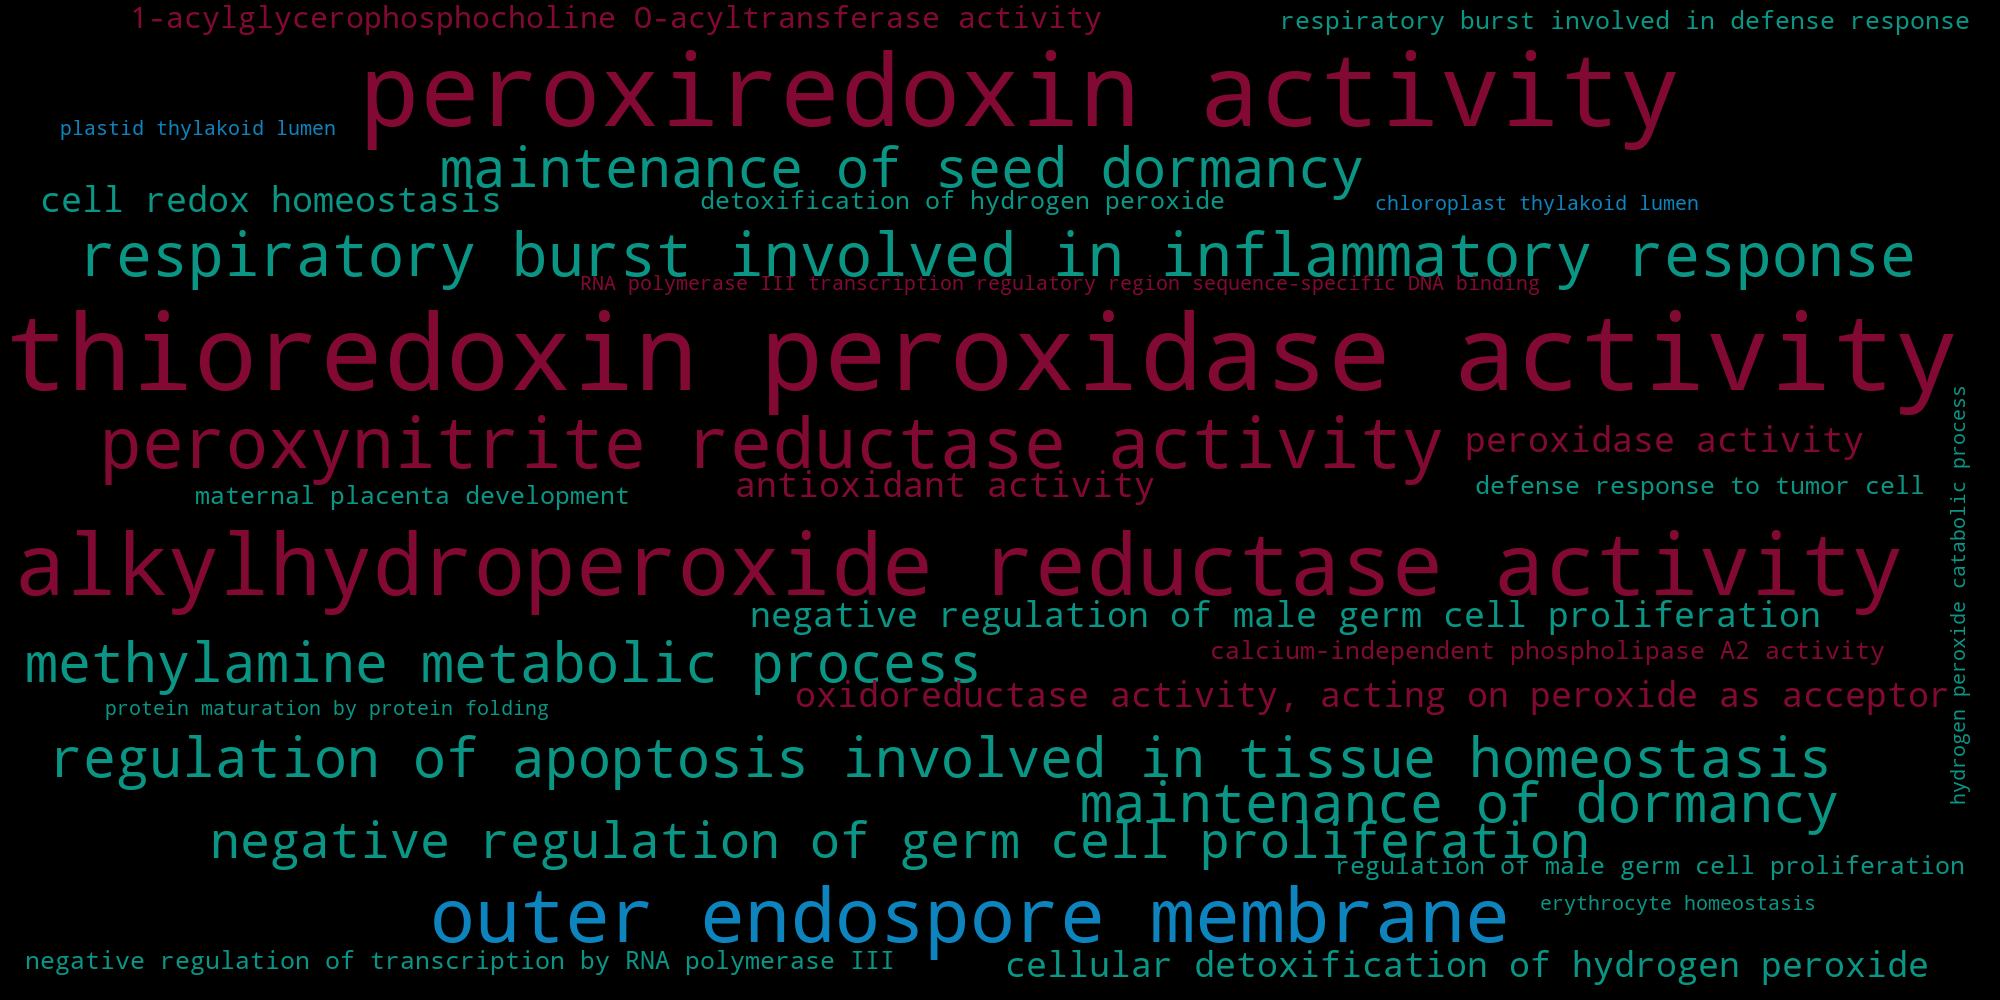

In [ ]:
#@title Generating Word Cloud for Enriched Gene Ontology Terms

from wordcloud import WordCloud

wc = WordCloud(
    background_color="#000000",
    mode="RGBA",
    color_func = lambda *args, **kwargs: (18,10,143),
    max_words = 2000,
    scale = 5,
    collocations=False
    # font
)

frequencies = np.sqrt(pvals_sorted.set_index('description').fold_increase)
wc.generate_from_frequencies(frequencies)

color_to_words = {
    '#0A9584': dict_sub_tree['biological_process'],
    '#0E84BF': dict_sub_tree['cellular_component'],
    '#820933': dict_sub_tree['molecular_function']
}


default_color = 'grey'

grouped_color_func = GroupedColorFunc(color_to_words, default_color)

# Apply our color function
wc.recolor(color_func=grouped_color_func)

path_wc = f"{data_dir}/goa/wc.png"
wc.to_file(path_wc)
wc.to_image()

## Motifs

In [ ]:
#@title Extracting ELM Regex from TSV File

import csv

def extract_elm_regex_from_tsv(file_path):
    elm_regex_list = []

    with open(file_path, 'r', newline='') as tsvfile:
        # Skip the header lines
        for _ in range(5):
            next(tsvfile)

        reader = csv.DictReader(tsvfile, delimiter='\t')
        for row in reader:
            # Extract the Regex column
            regex = row.get("Regex")

            # Append to the list if Regex is not None
            if regex is not None:
                elm_regex_list.append(regex)

    return elm_regex_list

tsv_file_path = "{}/elm_classes.tsv".format(data_dir)
result = extract_elm_regex_from_tsv(tsv_file_path)

# Print the extracted ELM Regex
for regex in result[:10]:
    print(regex)


[DSTE][^P][^DEWHFYC]D[GSAN]
[ILV]..R[VF][GS].
(.RK)|(RR[^KR])
R.[RK]R.
[KR]R.
KR.
R...[KR]R.
[RK].[AILMFV][LTKF].
S[IVLMH]E[IVPFMLYAQR]GR.
E[IMPVL][MLVP]R.


In [ ]:
#@title Extracting Regex Patterns from Prosite DAT File

def extract_regex_from_dat(file_path):
    regex_list = []

    with open(file_path, 'r') as datfile:
        for line in datfile:
            # Check if the line starts with "PA"
            if line.startswith("PA"):
                # Extract the regex from the line
                # Assuming the regex is present after the last space on the line
                regex = line.split()[-1]

                # Append to the list if regex is not empty
                if regex:
                    regex_list.append(regex)

    return regex_list

dat_file_path = "{}/prosite.dat".format(data_dir)
result_dat = extract_regex_from_dat(dat_file_path)

# Print the extracted regex patterns
for regex_dat in result_dat[:10]:
    print(regex_dat)


N-{P}-[ST]-{P}.
[RK](2)-x-[ST].
[ST]-x-[RK].
[ST]-x(2)-[DE].
[RK]-x(2)-[DE]-x(3)-Y.
G-{EDRKHPFYW}-x(2)-[STAGCN]-{P}.
x-G-[RK]-[RK].
C-x-[DN]-x(4)-[FY]-x-C-x-C.
E-x(2)-[ERK]-E-x-C-x(6)-[EDR]-x(10,11)-[FYA]-[YW].
[DEQGSTALMKRH]-[LIVMFYSTAC]-[GNQ]-[LIVMFYAG]-[DNEKHS]-S-[LIVMST]-{PCFY}-


In [ ]:
combined_set = set(result).union(result_dat)

combined_list = list(combined_set)

print(len(combined_list))

2037


In [ ]:
#@title Extracting Disordered Regions from MOBIDB Lite CSV File

import csv

csv_file_path = f'{data_dir}/mobidb_lite_swissprot.csv'

protein_intervals_dict = {}

with open(csv_file_path, 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        protein_id = row[0]
        intervals_str = row[1]
        intervals = eval(intervals_str)
        protein_intervals_dict[protein_id] = intervals

for i, (protein_id, intervals) in enumerate(protein_intervals_dict.items()):
    print(f"Protein ID: {protein_id}, Intervals: {intervals}")
    if i == 9:
        break

Protein ID: P9WEU3, Intervals: [[1493, 1529]]
Protein ID: P9WEU4, Intervals: [[1, 84], [118, 141]]
Protein ID: P0DTH5, Intervals: [[1, 38]]
Protein ID: P0DO34, Intervals: [[1, 24]]
Protein ID: P0DO30, Intervals: [[2520, 2583], [2597, 2621]]
Protein ID: P0DO27, Intervals: [[1, 26]]
Protein ID: P0DUK1, Intervals: [[1, 53]]
Protein ID: Q6GZX1, Intervals: [[38, 60]]
Protein ID: Q6GZX3, Intervals: [[261, 294]]
Protein ID: Q6GZX0, Intervals: [[1, 20]]


In [ ]:
#@title Finding Pattern Matches in Protein Sequences

import re
from Bio import SeqIO

MIN_LENGTH = 0

seq_records = list(SeqIO.parse("{}/best-model-protein-lineage-1.fasta".format(data_dir), "fasta"))

all_matches = []
pattern_counts = {}

for regex in combined_list:
    count = 0
    for record in seq_records:
        protein_id = record.id.split("_")[1]
        matches = []
        for match in re.finditer(regex, str(record.seq)):
            start, end = match.start(), match.end()
            if protein_id in protein_intervals_dict.keys() and any(pos[0] <= start and end <= pos[1] for pos in protein_intervals_dict[protein_id]):
              matched_sequence = match.group()
              if(len(matched_sequence) >= MIN_LENGTH):
                matches.append((record.name, regex, matched_sequence, start, end))
                pattern_counts.setdefault(regex, 0)
                pattern_counts[regex] += 1
        all_matches.extend(matches)

print("Number of matches:", len(all_matches))

for match in all_matches[:10]:
    print(f"Record: {match[0]}, Regex: {match[1]}, Matched Sequence: {match[2]} Start: {match[3]}, End: {match[4]}")

print(pattern_counts)

Number of matches: 4062
Record: UniRef90_Q96291, Regex: L., Matched Sequence: LI Start: 9, End: 11
Record: UniRef90_Q96291, Regex: L., Matched Sequence: LI Start: 9, End: 11
Record: UniRef90_Q9MB35, Regex: L., Matched Sequence: LK Start: 48, End: 50
Record: UniRef90_Q6UBI3, Regex: L., Matched Sequence: LS Start: 3, End: 5
Record: UniRef90_Q6UBI3, Regex: L., Matched Sequence: LP Start: 5, End: 7
Record: UniRef90_Q6UBI3, Regex: L., Matched Sequence: LP Start: 14, End: 16
Record: UniRef90_P40553, Regex: L., Matched Sequence: LA Start: 24, End: 26
Record: UniRef90_Q96CM4, Regex: L., Matched Sequence: LF Start: 210, End: 212
Record: UniRef90_Q8VC33, Regex: L., Matched Sequence: LW Start: 215, End: 217
Record: UniRef90_Q06830, Regex: [LIVMFC]., Matched Sequence: IK Start: 183, End: 185
{'L.': 9, '[LIVMFC].': 45, '[LIVM].': 34, '[GSTAP].': 117, '[LIVMFA].': 58, '[PV].': 45, '[PSA].': 81, '...([ST])P[RK]': 1, '[GAS].': 80, '.W[ACGILV]$': 1, '[SGT].': 78, '[ST].': 56, 'RV.P.': 2, '[LIVMFRY].': 

In [ ]:
#@title Statistical Analysis of Pattern Occurrences in Protein Sequences

import numpy as np

expected = np.mean([count for pattern, count in pattern_counts.items()])
std = np.std([count for pattern, count in pattern_counts.items()])
print("Mean occurences {:.3}\nSTD {:.3}".format(expected, std))

# Calculate Z-score
c = 0
for pattern, count in pattern_counts.items():
  c += 1
  print("{:<20} {:<10,} {:.3}".format(pattern, count, (count - expected) / std))
  if c >= 10:
    break

Mean occurences 39.8
STD 41.9
L.                   9          -0.735
[LIVMFC].            45         0.123
[LIVM].              34         -0.139
[GSTAP].             117        1.84
[LIVMFA].            58         0.433
[PV].                45         0.123
[PSA].               81         0.982
...([ST])P[RK]       1          -0.926
[GAS].               80         0.958
.W[ACGILV]$          1          -0.926


In [ ]:
#@title Filter patterns with z-score > 2
filtered_patterns = {pattern: count for pattern, count in pattern_counts.items() if (count - expected) / std > 2}

print("\nFiltered Patterns with Z-score > 2:")
for pattern, count in filtered_patterns.items():
    z_score = (count - expected) / std
    print("{:<20} {:<10,} {:.3}".format(pattern, count, z_score))



Filtered Patterns with Z-score > 2:
[GSTADNEKR].         164        2.96
[SGADNIT].           130        2.15
[LIVMFYSTAGPC].      141        2.41
[GSTACKRNQ].         151        2.65
[GSTPCEQ].           140        2.39
